# ProbNum Quickstart

ProbNum implements probabilistic numerical methods in Python. Such methods quantify _uncertainty arising from finite computation_ or from _stochastic input_.

Below we explain how to get started with ProbNum and its basic functionality.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18 
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsfonts}', 
                                       r'\usepackage{amsmath}', 
                                       r'\usepackage{bm}']

## Installation

You can install ProbNum using `pip` (or `pip3`).
```bash
pip install probnum
```
Alternatively, you can install the latest version from source.

```bash
pip install git+https://github.com/probabilistic-numerics/probnum.git
```
Then in a Python session simply import ProbNum.

In [2]:
import probnum as pn

## Basic Concepts

The main objects of interest in ProbNum are random variables. `RandomVariable`s have a `Distribution` which models the (numerical) uncertainty on the variable in question.

In [3]:
import numpy as np
from probnum.prob import RandomVariable, Normal

np.random.seed(1)

In [4]:
x = RandomVariable(distribution=Normal(0, 1))
print(x.sample())

1.6243453636632417


`RandomVariable`s behave similarly to NumPy arrays and support basic arithmetic, indexing and slicing.

In [5]:
y = 2 * x + 1
print(f"Mean: {y.mean()} and covariance: {y.cov()} of y.")

Mean: 1.0 and covariance: 4.0 of y.


## Probabilistic Numerical Methods

PN methods solve numerical problems (e.g. solution of linear systems, quadrature, differential equations, ...) by treating them as _statistical inference problems_ instead.

At a basic level they can serve as drop-in replacements for classic numerical routines.

In [6]:
# Linear System Ax=b
A = np.array([[7.5, 2.0, 1.0],
              [2.0, 2.0, 0.5],
              [1.0, 0.5, 5.5]])
b = np.array([1, 2, -3])

# Solve using NumPy
x = np.linalg.solve(A, b)
print(x)

# Solve using ProbNum
x_rv, _, _, info = pn.linalg.problinsolve(A, b)
print(x_rv.mean())

[-0.12366738  1.28358209 -0.63965885]
[-0.12366738  1.28358209 -0.63965885]


However, probabilistic numerical methods return random variables instead of just numbers. Their distribution models the uncertainty arising from finite computation or stochastic input.

In [7]:
# Solve with limited computational budget
x_rv, _, _, _ = pn.linalg.problinsolve(A, b, maxiter=2)

 /Users/jwenger/.virtualenvs/probnum/lib/python3.7/site-packages/probnum/linalg/linearsolvers/matrixbased.py:196: UserWarning:Iteration terminated. Solver reached the maximum number of iterations.


In [8]:
# Covariance of solution representing uncertainty
print(f"Covariance matrix: \n{x_rv.cov().todense()}")

Covariance matrix: 
[[ 2.23355410e-01 -7.52102244e-01  7.23806730e-03]
 [-7.52102244e-01  2.53254571e+00 -2.43726653e-02]
 [ 7.23806730e-03 -2.43726653e-02  2.34557194e-04]]


In [9]:
# Sample from output random variable
n_samples = 3
x_samples = x_rv.sample(n_samples)

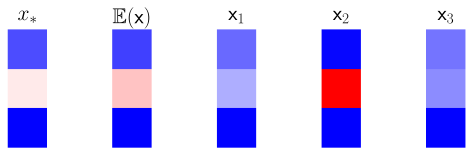

In [10]:
# Plot of true solution, mean and samples
rvdict = {"$x_*$" : x, "$\mathbb{E}(\mathsf{x})$" : x_rv.mean(), 
          "$\mathsf{x}_1$" : x_samples[0], "$\mathsf{x}_2$" : x_samples[1], "$\mathsf{x}_3$" : x_samples[2]}
vmin = np.min([np.min(mat) for mat in list(rvdict.values())])
vmax = np.max([np.max(mat) for mat in list(rvdict.values())])

fig, axes = plt.subplots(nrows=1, ncols=2 + n_samples, figsize=(8, 2.5), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv[:, np.newaxis], vmin=vmin, vmax=vmax, cmap="bwr")
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

Here, the probabilistic linear solver has identified the third component of the solution already with a high degree of confidence, while there is still some uncertainty about the first two left due to early termination.

### Encoding Prior Knowledge

If we have prior knowledge about the problem setting, we can encode this into a PN method by specifying a prior distribution on the input. For this problem we observe that the matrix $A$ is symmetric. Additionally, suppose we are given an approximate inverse of the system matrix. 

In [11]:
# Approximate inverse of A
Ainv_approx = np.array([[ 0.2  , -0.18, -0.015],
                        [-0.18 ,  0.7 , -0.03 ],
                        [-0.015, -0.03,  0.20 ]])
print(A @ Ainv_approx)

[[1.125  0.02   0.0275]
 [0.0325 1.025  0.01  ]
 [0.0275 0.005  1.07  ]]


For this problem we encode the symmetry of the system matrix and its inverse by using symmetric matrix-variate normal distributions as priors. Realizations of these priors are symmetric matrices. Since there is no stochasticity in the problem definition we choose a highly concentrated symmetric prior over $A$. This codifies our certainty about (multiplications with) $A$. For the prior over the inverse we choose the approximate inverse from above as a mean.

In [12]:
from probnum.linalg.linops import SymmetricKronecker, Identity

# Prior distribution(s)
A0 = RandomVariable(distribution=Normal(mean=A, 
                                        cov=SymmetricKronecker(10 ** -6 * Identity(A.shape[0]))))
Ainv0 = RandomVariable(distribution=Normal(mean=Ainv_approx, 
                                           cov=SymmetricKronecker(0.1 * Identity(A.shape[0]))))

We now solve the problem again, but this time we also pass the prior distributions to the solver.

In [13]:
# Solve linear system with limited computational budget and prior knowledge
x_rv, _, _, info = pn.linalg.problinsolve(A, b, A0=A0, Ainv0=Ainv0, maxiter=2)
print(info)

{'iter': 2, 'maxiter': 2, 'resid_l2norm': 0.00014783150371253874, 'conv_crit': 'maxiter', 'rel_cond': None}


 /Users/jwenger/.virtualenvs/probnum/lib/python3.7/site-packages/probnum/linalg/linearsolvers/matrixbased.py:196: UserWarning:Iteration terminated. Solver reached the maximum number of iterations.


### Examining the Posterior

We now take another look at the uncertainty in the solution, given prior knowledge about the inverse.

In [14]:
# Covariance of solution representing uncertainty
print(f"Covariance matrix: \n{x_rv.cov().todense()}")

Covariance matrix: 
[[0.00037817 0.0015451  0.00064998]
 [0.0015451  0.00631279 0.00265563]
 [0.00064998 0.00265563 0.00111716]]


In [15]:
# Sample from output random variable
n_samples = 3
x_samples = x_rv.sample(n_samples)

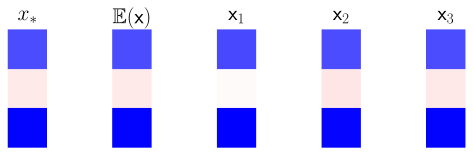

In [16]:
# Plot of true solution, mean and samples
rvdict = {"$x_*$" : x, "$\mathbb{E}(\mathsf{x})$" : x_rv.mean(), 
          "$\mathsf{x}_1$" : x_samples[0], "$\mathsf{x}_2$" : x_samples[1], "$\mathsf{x}_3$" : x_samples[2]}

fig, axes = plt.subplots(nrows=1, ncols=2 + n_samples, figsize=(8, 2.5), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv[:, np.newaxis], vmin=vmin, vmax=vmax, cmap="bwr")
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

We observe that after the same number of steps in our algorithm all components are approximately identified and the uncertainty in the output is much lower. 

_Remark:_ The reader familiar with linear solvers might recognize that the prior on the inverse plays a similar role to the preconditioner for classic linear solvers.